# StyleGAN2

This notebook demonstrates how to run NVIDIA's StyleGAN2 on Google Colab.
Make sure to specify a GPU runtime.

This notebook mainly adds a few convenience functions. 

For information on StyleGAN2, see:

Paper: https://arxiv.org/abs/1812.04948

Video: https://youtu.be/kSLJriaOumA

Code: https://github.com/NVlabs/stylegan

FFHQ: https://github.com/NVlabs/ffhq-dataset

/Mikael Christensen, 2019.


Adaptation : [@sioudayassin](https://twitter.com/SioudaYassin)


License : [CC BY-NC 4.0 ](https://creativecommons.org/licenses/by-nc/4.0/deed.fr)



# **READ CAREFULLY BEFORE LAUNCHING**

To use the generator you will have to host the model files by yourself on Google Drive

Once uploaded modify the cell **Double click me to add the path to your model files** by adding Google drive path to your file



Here you can find the download links to those used in this collab :


**Flickr Faces**

- Repo : https://github.com/justinpinkney/awesome-pretrained-stylegan2

- Download : http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-e.pkl

**Cats**

- Repo : https://github.com/justinpinkney/awesome-pretrained-stylegan2

- Download : http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-cat-config-f.pkl



**Abstract Art**

- Repo : https://github.com/justinpinkney/awesome-pretrained-stylegan2

- Download : https://drive.google.com/uc?id=1YzZemZAp7BVW701_BZ7uabJWJJaS2g7v


**Fursonna**
- Repo : https://github.com/justinpinkney/awesome-pretrained-stylegan2
- Download : https://thisfursonadoesnotexist.com/model/network-e621-r-512-3194880.pkl


**Painting Faces**
- Repo : https://github.com/justinpinkney/awesome-pretrained-stylegan2#faces-FFHQ-config-f-512x512
- Download : https://drive.google.com/uc?id=1H-MYFZqngF1R0whm4bc3fEoX7VvOWaDl


**Ukiyoe faces**
- Repo : https://github.com/justinpinkney/awesome-pretrained-stylegan2#faces-FFHQ-config-f-512x512
- Download : https://drive.google.com/uc?id=1_QysUKfed1-_x9e5off2WWJKp1yUcidu






In [ ]:
#@title #**Setup everything** { display-mode: "form" }
%tensorflow_version 1.x
import tensorflow as tf
 
# Download the code
!git clone https://github.com/NVlabs/stylegan2.git
%cd stylegan2
!pip install wget
!mkdir model
!nvcc test_nvcc.cu -o test_nvcc -run
 
print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))
 
# Useful utility functions...
 
# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]
 
    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       
 
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs
 
def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs
 
# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)
 
def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)
 
def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp
 
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
 
        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas
 
def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent
 
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out
 
# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
 
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'
 
    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
 
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

TensorFlow 1.x selected.
Cloning into 'stylegan2'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 591.89 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/stylegan2
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=9054ce8473c14340b5efef2d6690f132a7db5db59c351ec776029e90f248e9d3
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla T4 (UUID: GPU-7d06f9e8-e81c-b0b5-ed36-95d885c07084)
GPU Identified at: /device:GPU:0


# Mount your google drive account



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title #**Double click me to add the path to your model files** 
models = {}
models['flikr_faces'] = '/content/drive/My Drive/Colab Notebooks/stylegan/models/eurorack_modules/eurorack_modules_v2_1024.pkl'  
models['abstract_art'] = '/content/drive/My Drive/PathToMyModel'  
models['figure_drawing'] = '/content/drive/My Drive/PathToMyModel' 
models['floor_plans'] = '/content/drive/My Drive/PathToMyModel' 
models['fursona'] = '/content/drive/My Drive/PathToMyModel'  
models['cats'] = '/content/drive/My Drive/PathToMyModel'  
models['celebrities'] = '/content/drive/My Drive/PathToMyModel'  
models['painting_face'] = '/content/drive/My Drive/PathToMyModel' 
models['ukiyoe_faces'] = '/content/drive/My Drive/PathToMyModel'  




In [ ]:
#@title #**Model selector** { run: "auto", display-mode: "form" }
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import wget
import pretrained_networks
import os
model_selector = "flikr_faces"  #@param ['ukiyoe_faces','painting_face','celebrities','cats','flikr_faces','abstract_art','figure_drawing','floor_plans','fursona']
 
print(model_selector)
 
network_pkl = models[model_selector]
 
print(network_pkl)
 
 
print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

flikr_faces
/content/drive/My Drive/Colab Notebooks/stylegan/models/eurorack_modules/eurorack_modules_v2_1024.pkl
Loading networks from "/content/drive/My Drive/Colab Notebooks/stylegan/models/eurorack_modules/eurorack_modules_v2_1024.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


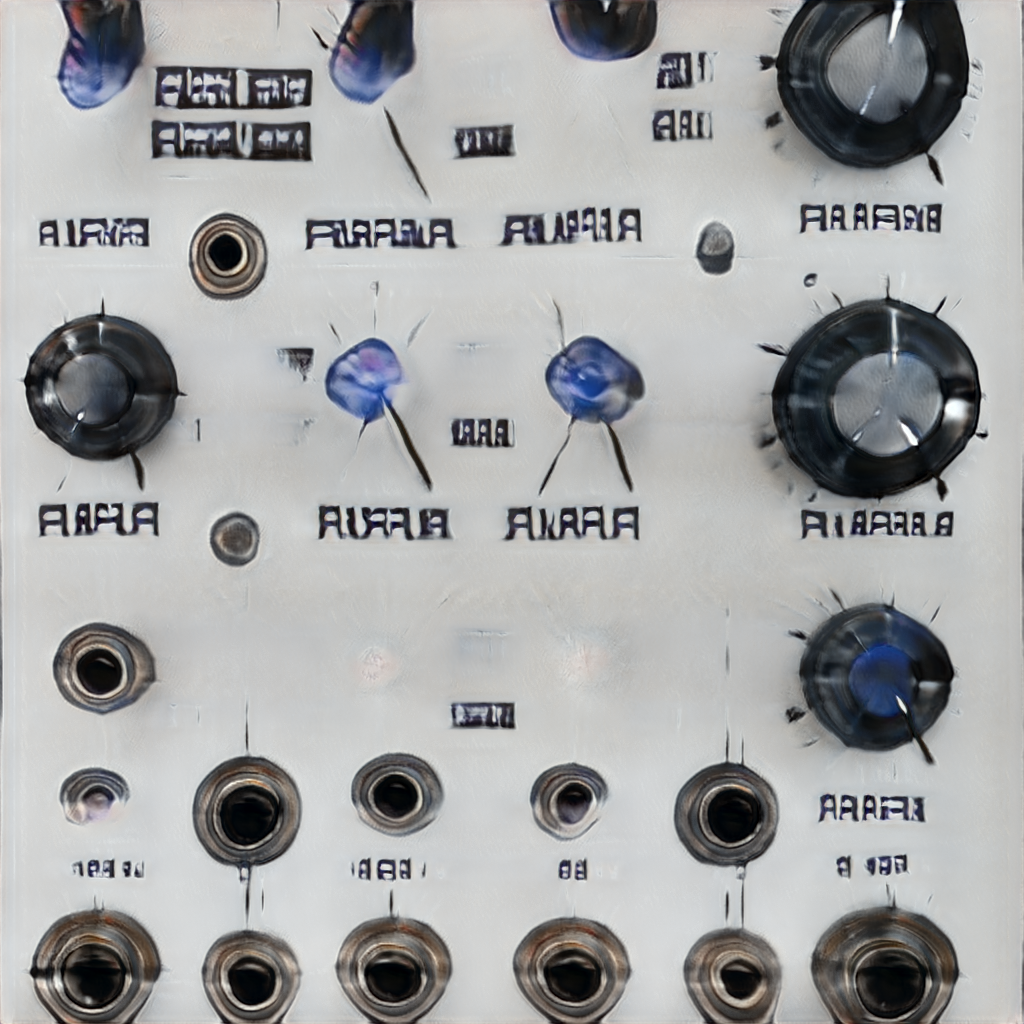

In [ ]:
#@title #**Generate an image** { run: "auto", display-mode: "form" }
from google.colab import files
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
 
Gs_kwargs = dnnlib.EasyDict()
Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
Gs_kwargs.randomize_noise = False
 
seed = 135 #@param {type:"slider", min:1, max:500, step:1}
 
truncation_psi = 0.5 #@param {type:"slider", min:0, max:2, step:0.5}
Gs_kwargs.truncation_psi = truncation_psi

 
#print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
PIL.Image.fromarray(images[0], 'RGB').save(str(seed) + '.png')
 
isp = IPython.display.display(IPython.display.Image(str(seed) + '.png'))

In [ ]:
#@title #**Generate a video** {display-mode: "form" }
 
# generating a MP4 movie
 
start_seed = 55 #@param {type:"slider", min:0, max:500, step:5}
stop_seed = 20060 #@param {type:"slider", min:0, max:50000, step:5}
 
zs = generate_zs_from_seeds([start_seed,stop_seed])
 
number_of_steps = 20 #@param {type:"slider", min:0, max:130, step:10}

truncation_psi = 0.5 #@param {type:"slider", min:0, max:2, step:0.5}

imgs = generate_images(interpolate(zs,number_of_steps), truncation_psi)
 
# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'
 
with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))
 
 
from IPython.display import HTML
from base64 import b64encode
mp4 = open(movieName,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)